In [1]:
import os
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms, models # add models to the list
from sklearn.metrics import classification_report

In [2]:
# check if GPU is available 
torch.cuda.is_available()

True

In [3]:
PROJECT_ROOT = os.getcwd()

In [4]:
root = os.path.join(PROJECT_ROOT, 'brain tumor data')

In [5]:
test_path = root+'/test/'
train_path = root+'/train/'
validation_path = root + '/valid/'

In [6]:
train_img_dir = root + '/train'
valid_img_dir = root + '/valid'

In [7]:
# define transformers
train_transform = transforms.Compose([
        transforms.RandomAffine(degrees=0, shear=5, scale=(0.95,1.05)),
        transforms.RandomRotation(3),      
        transforms.RandomHorizontalFlip(p=0.5),  # reverse 50% of images
        transforms.RandomVerticalFlip(p=0.3),  # reverse 30% of images
        transforms.GaussianBlur(3, sigma=(0.1, 1.0)),
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ])


valid_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ])

In [8]:
import json
from torch.utils.data import Dataset
from PIL import Image

In [9]:
# load annotation and get image path and labels
class TumorDataset(Dataset):
    def __init__(self, fixed_annotation_file, image_dir, transform=None):
        with open(fixed_annotation_file, 'r') as f:
            coco_data = json.load(f)
        
        # mapping image_id to category_id
        image_id_to_label = {ann['image_id']: ann['category_id'] for ann in coco_data['annotations']}

        self.samples = []
        for img in coco_data['images']:
            file_name = img['file_name']
            img_id = img['id']
            label = image_id_to_label.get(img_id) # use get(img_id) is to look up the category_id(label) for the image using its ID

            if label is not None:
                image_path = os.path.join(image_dir, file_name)
                self.samples.append((image_path, label-1))
            
        self.transform = transform
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


In [10]:
train_data = TumorDataset(
    fixed_annotation_file = root + '/train/fixed_annotations.json',
    image_dir = train_img_dir,
    transform=train_transform
)
valid_data = TumorDataset(
    fixed_annotation_file = root + '/valid/_annotations.coco.json',
    image_dir = valid_img_dir,
    transform = valid_transform   
)

# start to load pre-trained ResNet18 model and fine-tune
import os
import time
from tqdm import tqdm
import numpy as np
import random
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torch.optim.lr_scheduler import CosineAnnealingLR
import shutil

save_dir_vit = os.path.join(PROJECT_ROOT, 'base_Vit_B_16_new')
os.makedirs(save_dir_vit,exist_ok = True)

num_runs = 3
train_accuracies_all = []
valid_accuracies_all = []
train_losses_all = []
valid_losses_all = []
all_train_acc = []
all_val_acc =[]
all_train_loss = []
all_val_loss =[]
# track the best val loss of each run 
best_val_losses_all = []



for run in range(num_runs):
    print(f"\n===== Run {run+1} =====\n")
    torch.manual_seed(42 + run)
    torch.cuda.manual_seed(42 + run)
    np.random.seed(42 + run)
    random.seed(42 + run)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    train_loader = DataLoader(train_data, batch_size = 32, shuffle=True)
    valid_loader = DataLoader(valid_data, batch_size = 32, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # load pretrained ResNet18 model
    model = models.vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
    # freeze all layers
    for param in model.parameters():
        param.requires_grad = False
    
    # unfreeze last 2 transformer blocks and the classification head
    for name, param in model.named_parameters():
        if "encoder.layers.7" in name or "encoder.layers.8" in name or "encoder.layers.9" in name or "encoder.layers.10" in name or "encoder.layers.11" in name or "heads" in name:
            param.requires_grad = True
    

    model.heads = nn.Sequential(
        nn.Dropout(0.4),
        nn.Linear(model.heads.head.in_features, 2)
    
    )
    model = model.to(device)
    
    # define the loss and optimizer 
    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    opt_Vit = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay = 1e-5)
    scheduler = CosineAnnealingLR(opt_Vit, T_max =50, eta_min=1e-6)

    best_val_acc = 0
    best_model_path = os.path.join(save_dir_vit, f"best_vit_run{run+1}.pth")
    

    # train the model with early stopping

    epochs = 50 # Keep the high epoch count, early stopping will decide when to stop
    patience =6 # Stop training if validation loss does not improve for 'patience' epochs
    min_delta = 0.001 # Minimum change to qualify as an improvement
    best_val_loss = float('inf') # Track best validation loss
    counter = 0 # Track consecutive epochs without improvement
    best_model_path = os.path.join(save_dir_vit, f'best_vit_run{run+1}.pth')

    train_losses = []
    valid_losses= []
    train_accuracies = []
    valid_accuracies= []

     # track best epoch metircs
    val_accuracy_at_best_loss = None
    train_accuracy_at_best_loss = None
    train_loss_at_best_loss = None
    val_loss_at_best_loss = None

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        train_correct = 0
        total_train = 0
    
    # Run the training batches
        for b, (X_train, y_train) in enumerate(train_loader):
            b+=1
            X_train, y_train = X_train.to('cuda'), y_train.to('cuda')
        
            # forward pass
            outputs = model(X_train)
            loss = criterion(outputs, y_train)

            # backward propagation 
            opt_Vit.zero_grad()
            loss.backward()
            opt_Vit.step()

            # track loos and accuracy
            epoch_train_loss += loss.item()
            preds = outputs.argmax(dim=1)
            train_correct += (preds == y_train).sum().item()
            total_train += y_train.size(0)

            # optional debug
            if b%20 == 0:
                print(f"Batch {b}, Loss: {loss.item():.4f}")

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_accuracy = train_correct / total_train

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # validation part
        model.eval()
        epoch_val_loss = 0.0
        val_correct = 0
        total_val = 0

        with torch.no_grad():
            for X_val, y_val in valid_loader:
                X_val, y_val = X_val.to('cuda'), y_val.to('cuda')

                outputs = model(X_val)
                loss = criterion(outputs, y_val)

                epoch_val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                val_correct += (preds == y_val).sum().item()
                total_val += y_val.size(0)
       
           
        avg_val_loss = epoch_val_loss / len(valid_loader)
        val_accuracy = val_correct / total_val

        valid_losses.append(avg_val_loss)
        valid_accuracies.append(val_accuracy)

  

        print(f"Epoch: {epoch+1} - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4g} | "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
      
        
        # **Early stopping logic**
        if avg_val_loss < best_val_loss - min_delta:
            best_val_loss = avg_val_loss # Update best loss
            val_accuracy_at_best_loss = val_accuracy
            train_accuracy_at_best_loss = train_accuracy
            train_loss_at_best_loss = avg_train_loss
            val_loss_at_best_loss = avg_val_loss
            counter = 0 # Reset counter

            # save the best model for this run
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved at epoch {epoch+1}")
        else:
            counter += 1 # Increase counter
            if counter >= patience: # Stop if no improvement for 'patience' epochs
                print(f"Early stopping at epoch {epoch+1} (No improvement for {patience} epochs)")
                break
    #save metrics from each run
    all_train_acc.append(train_accuracy_at_best_loss)
    all_val_acc.append(val_accuracy_at_best_loss)
    all_train_loss.append(train_loss_at_best_loss)
    all_val_loss.append(val_loss_at_best_loss)   
    best_val_losses_all.append(best_val_loss)

    # save full per-epoch history
    train_accuracies_all.append(train_accuracies)
    valid_accuracies_all.append(valid_accuracies)
    train_losses_all.append(train_losses)
    valid_losses_all.append(valid_losses)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # Print time elapsed
# final results
print("\n===== Final Average Results ======\n")
print(f"Train Accuracy: {np.mean(all_train_acc):.4f} +- {np.std(all_train_acc):.4f}")
print(f"Valid Accuracy: {np.mean(all_val_acc):.4f} +- {np.std(all_val_acc):.4f}")
print(f"Train Loss: {np.mean(all_train_loss):.4f} +- {np.std(all_train_loss):.4f}")
print(f"Valid Loss: {np.mean(all_val_loss):.4f} +- {np.std(all_val_loss):.4f}")

# save only the best model across runs
best_run_idx = np.argmin(best_val_losses_all)
best_model_path = os.path.join(save_dir_vit, f"best_vit_run{best_run_idx + 1}.pth")
final_best_model_path = os.path.join(save_dir_vit, 'best_vit_overall.pth')
shutil.copy(best_model_path, final_best_model_path)
print(f"n\Best overall model was from run {best_run_idx + 1} with val loss {best_val_losses_all[best_run_idx]:.4f}")
print("\nsaved to:", os.path.relpath(final_best_model_path))






===== Run 1 =====

Batch 20, Loss: 0.6303
Batch 40, Loss: 0.5798
Epoch: 1 - Train Loss: 0.6192, Train Acc: 0.6611 | Val Loss: 0.4346, Val Acc: 0.8601
Best model saved at epoch 1
Batch 20, Loss: 0.4438
Batch 40, Loss: 0.5818
Epoch: 2 - Train Loss: 0.5216, Train Acc: 0.785 | Val Loss: 0.3778, Val Acc: 0.8974
Best model saved at epoch 2
Batch 20, Loss: 0.4501
Batch 40, Loss: 0.3948
Epoch: 3 - Train Loss: 0.5059, Train Acc: 0.7976 | Val Loss: 0.3544, Val Acc: 0.9044
Best model saved at epoch 3
Batch 20, Loss: 0.4101
Batch 40, Loss: 0.4454
Epoch: 4 - Train Loss: 0.4967, Train Acc: 0.8056 | Val Loss: 0.3470, Val Acc: 0.9091
Best model saved at epoch 4
Batch 20, Loss: 0.4120
Batch 40, Loss: 0.4457
Epoch: 5 - Train Loss: 0.4803, Train Acc: 0.8149 | Val Loss: 0.3437, Val Acc: 0.9138
Best model saved at epoch 5
Batch 20, Loss: 0.5515
Batch 40, Loss: 0.5115
Epoch: 6 - Train Loss: 0.4780, Train Acc: 0.8276 | Val Loss: 0.3324, Val Acc: 0.9207
Best model saved at epoch 6
Batch 20, Loss: 0.4450
Batc

In [11]:
# visulize train and valid loss
import matplotlib.pyplot as plt
import numpy as np

In [12]:
max_len = max(len(run) for run in train_accuracies_all)

In [13]:
def pad_to_max(arr_list, max_len):
    return np.array([np.pad(run, (0, max_len - len(run)), constant_values=np.nan) for run in arr_list])

train_accuracies_pad = pad_to_max(train_accuracies_all, max_len)
valid_accuracies_pad = pad_to_max(valid_accuracies_all, max_len)
train_losses_pad = pad_to_max(train_losses_all, max_len)
valid_losses_pad = pad_to_max(valid_losses_all, max_len)

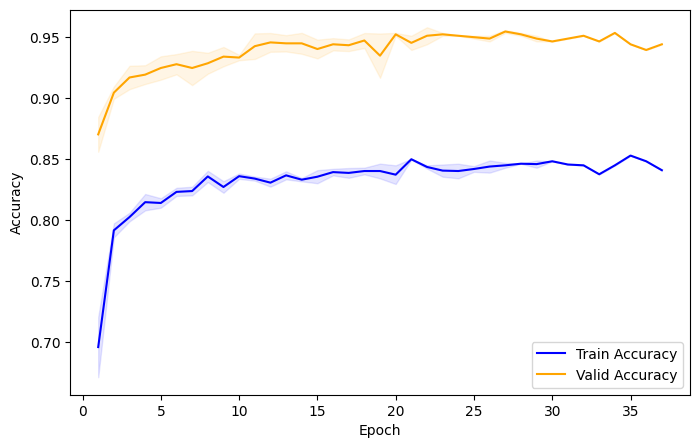

In [14]:
epochs = list(range(1, max_len + 1))
mean_train_acc = np.nanmean(train_accuracies_pad, axis=0)
std_train_acc = np.nanstd(train_accuracies_pad, axis=0)

mean_valid_acc = np.nanmean(valid_accuracies_pad, axis=0)
std_valid_acc = np.nanstd(valid_accuracies_pad, axis=0)


plt.figure(figsize = (8,5))
plt.plot(epochs, mean_train_acc, label='Train Accuracy', color = 'blue')
plt.fill_between(epochs, mean_train_acc - std_train_acc, mean_train_acc + std_train_acc, alpha = 0.1, color = 'blue')

plt.plot(epochs, mean_valid_acc, label='Valid Accuracy', color = 'orange')
plt.fill_between(epochs, mean_valid_acc - std_valid_acc, mean_valid_acc + std_valid_acc, alpha = 0.1, color = 'orange')

plt.title('')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
def pad_to_max(loss_list, max_len):
    return np.array([np.pad(run, (0, max_len - len(run)), constant_values=np.nan) for run in loss_list])

#train_losses_pad = pad_to_max(train_losses_all, max_len)
#valid_losses_pad = pad_to_max(valid_losses_all, max_len)
train_losses_pad = pad_to_max(train_losses_all, max_len)
valid_losses_pad = pad_to_max(valid_losses_all, max_len)

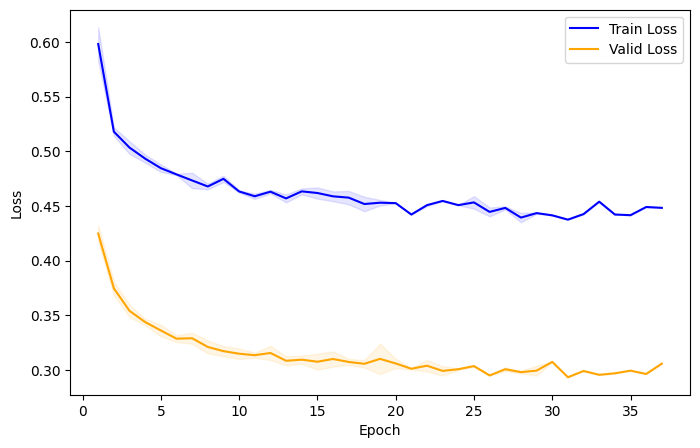

In [16]:
epochs = list(range(1, max_len + 1))
mean_train_loss = np.nanmean(train_losses_pad, axis=0)
std_train_loss = np.nanstd(train_losses_pad, axis=0)

mean_valid_loss = np.nanmean(valid_losses_pad, axis=0)
std_valid_loss = np.nanstd(valid_losses_pad,axis=0)

epochs = list(range(1, len(mean_train_loss)+1))

plt.figure(figsize = (8,5))
plt.plot(epochs, mean_train_loss, label='Train Loss', color = 'blue')
plt.fill_between(epochs, mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, alpha = 0.1, color = 'blue')

plt.plot(epochs, mean_valid_loss, label='Valid Loss', color = 'orange')
plt.fill_between(epochs, mean_valid_loss - std_valid_loss, mean_valid_loss + std_valid_loss, alpha = 0.1, color = 'orange')

plt.title('')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
model_dir = os.path.join(PROJECT_ROOT, 'base_Vit_B_16_new')
model_filename = 'best_vit_overall.pth'
model_path = os.path.join(model_dir, model_filename)

In [18]:
model.load_state_dict(torch.load(model_path))
model  = model.to(device)
model.eval()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [19]:
import seaborn as sns
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to('cuda')
        labels = labels.to('cuda')

        outputs = model(images)
        _, preds = torch.max(outputs,1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [20]:
print("classification_report:\n")
print(classification_report(all_labels, all_preds))

classification_report:

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       210
           1       0.97      0.93      0.95       219

    accuracy                           0.95       429
   macro avg       0.95      0.95      0.95       429
weighted avg       0.95      0.95      0.95       429



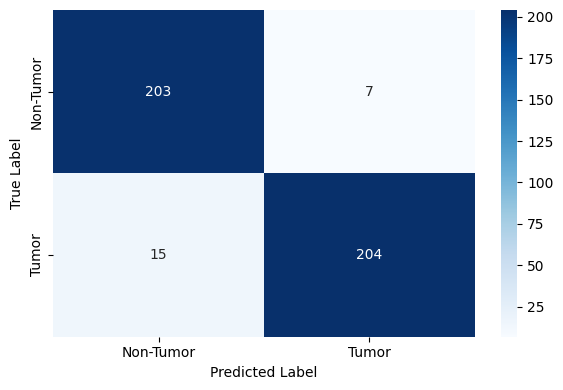

In [21]:
# confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Tumor', 'Tumor'],
            yticklabels=['Non-Tumor','Tumor'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('')
plt.tight_layout()
plt.show()